# 1. Imports

## 1.1 Libs

In [2]:
import sqlite3
import inflection

import pandas           as pd
import numpy            as np
import seaborn          as sns

from datetime           import datetime
from sqlalchemy         import create_engine

from matplotlib             import pyplot                   as plt


## 1.2 Loading Data

In [3]:
# Database Conection
host = 'irish-sea-db.cyllx5pgzqdx.us-east-1.rds.amazonaws.com'
port = '5432'
database = 'postgres'
user = 'postgres'
pwd = 'dadosfera'

endpoint_aws = f'postgresql://{user}:{pwd}@{host}/{database}'


engine = create_engine(endpoint_aws)
connection = engine.connect()

# Consulting Database
query = """ 
    SELECT * FROM tide
"""

df1 = pd.read_sql_query(query, engine)

connection.close()

## 1.3 Helper Function

In [24]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    concat = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    concat.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return concat

# 2. Data Understanding

## 2.1 Overview

### 2.1.1 Basic Data Structure

In [4]:
df2 = df1.copy()

In [5]:
df2.head()

,time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag
0,UTC,None,degrees_north,degrees_east,metres,metres,NaN
1,2021-09-01T00:00:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.492,0.289,1.0
2,2021-09-01T00:05:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.532,0.329,1.0
3,2021-09-01T00:10:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.532,0.329,1.0
4,2021-09-01T00:15:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.529,0.326,1.0


In [6]:
print(f'Number of Rows:{df2.shape[0]}')
print(f'Number of Columns:{df2.shape[1]}')

Number of Rows:1736639
Number of Columns:7


In [28]:
df2.dtypes

time                     object
station_id               object
latitude                 object
longitude                object
Water_Level_LAT          object
Water_Level_OD_Malin     object
QC_Flag                 float64
dtype: object

### 2.1.2 Features Description

| Feature                    | Definition
|----------------------------|---------------------------------------------------------------|
| time                       | Datetime when the row was registred                           |                               
| station_id                 | Station Name                                                  |       
| longitude                  | Geolocation                                                   |                                                                   
| latitude                   | Geolocation                                                   |  
| water_level_LAT            | Water level measured by LAT (lowest astronomical tide)        |                                               
| water_level_OD_Malin       | Water level measured by OD Malin                              |   
| qc_flag                    | Quality Control Flag                                          |    

* [Reference: OD Malin](https://en.wikipedia.org/wiki/Ordnance_datum)
* [Reference: LAT](https://en.wikipedia.org/wiki/Chart_datum)


## 2.2 Rename Columns

In [29]:
df2.columns

Index(['time', 'station_id', 'latitude', 'longitude', 'Water_Level_LAT',
       'Water_Level_OD_Malin', 'QC_Flag'],
      dtype='object')

In [30]:
cols_old = ['time', 'station_id', 'latitude', 'longitude', 'Water_Level_LAT',
       'Water_Level_OD_Malin', 'QC_Flag']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df2.columns = cols_new

df2.head()

,time,station_id,latitude,longitude,water_level_lat,water_level_od_malin,qc_flag
0,UTC,None,degrees_north,degrees_east,metres,metres,NaN
1,2021-09-01T00:00:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.492,0.289,1.0
2,2021-09-01T00:05:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.532,0.329,1.0
3,2021-09-01T00:10:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.532,0.329,1.0
4,2021-09-01T00:15:00Z,Aranmore Island - Leabgarrow,54.9905,-8.4955,2.529,0.326,1.0


## 2.3 Check and Fillout NA

In [31]:
df2.isna().sum()

time                         0
station_id                  20
latitude                     0
longitude                    0
water_level_lat         240463
water_level_od_malin         0
qc_flag                     20
dtype: int64

In [32]:
# As we have two ways to measure the water level, the water_level_lat column, which has many missing values, will be disregarded.
df2 = df2.drop(columns = ['water_level_lat'], axis=1)

In [33]:
df2 = df2.dropna()

In [34]:
df2.isna().sum()

time                    0
station_id              0
latitude                0
longitude               0
water_level_od_malin    0
qc_flag                 0
dtype: int64

## 2.4 Change Types

In [35]:
df2.dtypes

time                     object
station_id               object
latitude                 object
longitude                object
water_level_od_malin     object
qc_flag                 float64
dtype: object

In [36]:
# Time
df2['time'] = pd.to_datetime(df2['time']).dt.tz_localize(None)

# Latitude
df2['latitude'] = df2['latitude'].astype(float)

# Longitude
df2['longitude'] = df2['longitude'].astype(float)

# water_level_od_malin
df2['water_level_od_malin'] = df2['water_level_od_malin'].astype(float)

In [37]:
df2.dtypes

time                    datetime64[ns]
station_id                      object
latitude                       float64
longitude                      float64
water_level_od_malin           float64
qc_flag                        float64
dtype: object

In [38]:
df2.head()

,time,station_id,latitude,longitude,water_level_od_malin,qc_flag
1,2021-09-01 00:00:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.289,1.0
2,2021-09-01 00:05:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.329,1.0
3,2021-09-01 00:10:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.329,1.0
4,2021-09-01 00:15:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.326,1.0
5,2021-09-01 00:20:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.324,1.0


## 2.5 Basic Analysis

In [39]:
num_attributes = df2[['water_level_od_malin']]
cat_attributes = df2['station_id']

In [40]:
# Numerical Attributes
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,water_level_od_malin,-32.758,13.583,46.341,-0.079085,-0.054,1.064313,-0.417439,9.412163


* Note: the maximum sea level value above 13 meters and the median close to zero, indicates that we have an outlier in this attribute.

In [41]:
# Categorial attributes
df2[['station_id', 'water_level_od_malin']].groupby('station_id').count().reset_index()

,station_id,water_level_od_malin
0,Aranmore Island - Leabgarrow,96492
1,Ballycotton Harbour,49764
2,Ballyglass Harbour,104152
3,Castletownbere Port,85060
4,Dingle Harbour,98699
5,Dublin Port,104875
6,Dunmore East Harbour,91784
7,Galway Port,104874
8,Howth Water Level 1,101568
9,Inishmore,95906


In [42]:
# Period of time
print('Start: {}'.format(df2['time'].min()))
print('End: {}'.format(df2['time'].max()))

Start: 2021-09-01 00:00:00
End: 2022-08-31 23:55:00


# 3. Feature Engineering

## 3.1 Time-derived features

In [43]:
df3 = df2.copy()

In [44]:
# Date:
df3['date'] = df3['time'].dt.date

# Year:
df3['year'] = df3['time'].dt.year

# Month:
df3['month'] = df3['time'].dt.month

# Year_Month
df3['year_month'] = df3['time'].dt.strftime('%Y-%m')

# Day of Month
df3['day_of_month'] = df3['time'].dt.day

# Day of Week
df3['day_of_week'] = df3['time'].dt.day_of_week

# Hour
df3['hour'] = df3['time'].dt.hour

In [45]:
df3.head()

,time,station_id,latitude,longitude,water_level_od_malin,qc_flag,date,year,month,year_month,day_of_month,day_of_week,hour
1,2021-09-01 00:00:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.289,1.0,2021-09-01,2021,9,2021-09,1,2,0
2,2021-09-01 00:05:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.329,1.0,2021-09-01,2021,9,2021-09,1,2,0
3,2021-09-01 00:10:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.329,1.0,2021-09-01,2021,9,2021-09,1,2,0
4,2021-09-01 00:15:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.326,1.0,2021-09-01,2021,9,2021-09,1,2,0
5,2021-09-01 00:20:00,Aranmore Island - Leabgarrow,54.9905,-8.4955,0.324,1.0,2021-09-01,2021,9,2021-09,1,2,0


# 4. Data Filtering

## 4.1 Water Level

In [46]:
df4 = df3.copy()

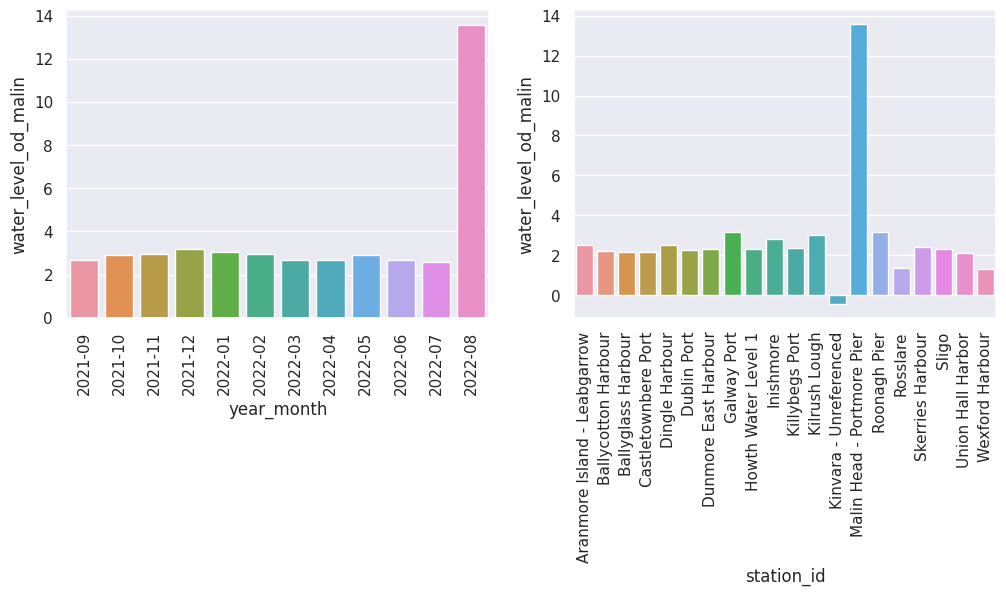

In [63]:
sns.set(rc={'figure.figsize':(12, 4)})

# To start the investigation about the outlier seen in the basic analysis section, let's see the max sea level per month:
plt.subplot(1, 2, 1)
max_level_month = df4[['year_month', 'water_level_od_malin']].groupby('year_month').max().reset_index()
sns.barplot(x='year_month', y='water_level_od_malin', data=max_level_month)
plt.xticks (rotation=90);

# And here the max sea level per buoy:
plt.subplot(1, 2, 2)
max_level_buoy = df4[['station_id', 'water_level_od_malin']].groupby('station_id').max().reset_index()
sns.barplot(x='station_id', y='water_level_od_malin', data=max_level_buoy)
plt.xticks (rotation=90);

Note: from this analysis we conclude that the discrepant value is concentrated in the month of August 2022 at Portmore Pier. To solve this discrepancy, we will filter August from Portmore Pier.

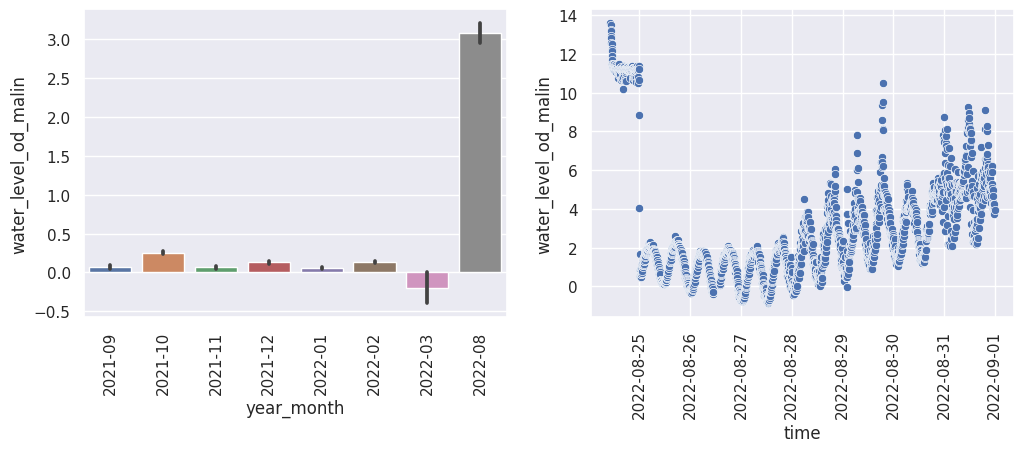

In [64]:
sns.set(rc={'figure.figsize':(12, 4)})

# Portmore Pier	Average Level per Month
plt.subplot(1, 2, 1)
aux1 = df4[(df4['station_id']=='Malin Head - Portmore Pier')]
sns.barplot(x='year_month', y='water_level_od_malin', data=aux1)
plt.xticks (rotation=90);

# Portmore Pier	Average Level August
plt.subplot(1, 2, 2)
aux1 = df4[(df4['station_id']=='Malin Head - Portmore Pier') & (df4['month']==8)]
sns.scatterplot(x='time', y='water_level_od_malin', data=aux1)
plt.xticks (rotation=90);

In [67]:
# Filtering Dataset
df4 = df4[~((df4['station_id']=='Malin Head - Portmore Pier') & (df4['month']==8))]

In [ ]:
# Save as .csv
# df4.to_csv('../data/sea_level.csv', index=False)

# 5. Exploratory Data Analysis

## 5.1 Univariate Analysis

### 5.1.1 Water Level

In [68]:
df5 = df4.copy()

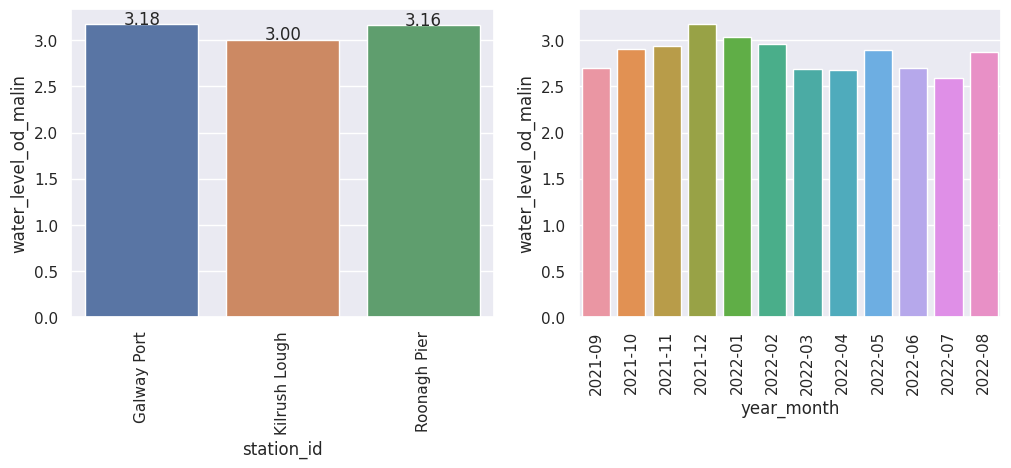

In [81]:
# Max Water Level per Buoy
plt.subplot(1, 2, 1)
max_level_buoy = df5[['station_id', 'water_level_od_malin']][df5['water_level_od_malin']>3].groupby('station_id').max().reset_index()
plot = sns.barplot(x='station_id', y='water_level_od_malin', data=max_level_buoy)
plt.xticks (rotation=90);
for i in plot.patches:
    height = i.get_height()
    total = len(max_level_buoy['water_level_od_malin'])
    plot.text(i.get_x() + i.get_width()/2, 
              height,
              '{:1.2f}'.format(height),
              ha='center')

# Max Water Lever per Month
plt.subplot(1, 2, 2)
max_level_month = df5[['year_month', 'water_level_od_malin']].groupby('year_month').max().reset_index()
sns.barplot(x='year_month', y='water_level_od_malin', data=max_level_month)
plt.xticks (rotation=90);

In [83]:
max_level_buoy = df5[['station_id', 'latitude', 'longitude', 'water_level_od_malin']][df5['water_level_od_malin']>3].groupby('station_id').max().reset_index()

max_level_buoy

,station_id,latitude,longitude,water_level_od_malin
0,Galway Port,53.26900,-9.04800,3.176
1,Kilrush Lough,52.63191,-9.50208,3.005
2,Roonagh Pier,53.76235,-9.90442,3.162
